In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
from scipy.integrate import quad
import time
from scipy.optimize import curve_fit
#tA)2p4KuGC.wqHH

In [2]:
# Constants and Parameters

# Lengths and elements
L_core = 200  # Length of the inner part of core in cm
pipe1 = 400  # Length of plenum in cm
pipe2 = 400 # Length of outer part of core in cm
L_he = 200  # Length of out of core part in cm
dz = 5  # Length of each volume element in the z direction in cm

total_length = L_core + pipe1 + pipe2 + L_he
n_elements = int(total_length / dz)
n_core = int((L_core) / dz)
n_pipe1 = int((pipe1) / dz)
n_pipe2 = int((pipe2) / dz)
n_he = int((L_he) / dz)

# Heat exchanger characteristics
OL = 259370  # Heat transfer area
L = 200 # Length of heat exchanger in cm
LL = L_he - L # Length of out of core region minus the heat exchanger

# Material characteristics
rho_fuel = 2263e-6  # Density of fuel in kg/cm^3
cp_fuel = 1982.5  # Specific heat of fuel in J/kgK
rho_graph = 2180e-6  # Density of graphite in kg/cm^3
cp_graph = 1750  # Specific heat of graphite in J/kgK
rho_cp_fuel = rho_fuel * cp_fuel
rho_cp_graph = rho_graph * cp_graph

volume_s = 818.8e3 
mass_g = 3715

w = 181.6 # massflowrate in kg/s

# Nuclear data
#235 U ornl
beta_eff_groups = np.array([22.3, 145.7, 130.7, 262.8, 76.6, 28]) * 1e-5
lambda_groups = np.array([0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01])
total_beta_eff = np.sum(beta_eff_groups)

#235 U JEF
# beta_eff_groups = np.array([25.93, 133.35, 127.44, 283.64, 116.9, 48.8]) * 1e-5
# lambda_groups = np.array([0.01272, 0.03174, 0.116, 0.311, 1.4, 3.87])
# total_beta_eff = np.sum(beta_eff_groups)

#233 U ornl
# beta_eff_groups = np.array([23.76, 85.76, 71.90, 82.14, 15.79, 10.03]) * 1e-5
# lambda_groups = np.array([0.0126, 0.0337, 0.139, 0.325, 1.13, 2.5])
# total_beta_eff = np.sum(beta_eff_groups)

#233 JEF
# beta_eff_groups = np.array([26.4, 67.6, 70.1, 118.9, 33.9, 9.4]) * 1e-5
# lambda_groups = np.array([0.01272, 0.03174, 0.116, 0.311, 1.4, 3.87])
# total_beta_eff = np.sum(beta_eff_groups)

# Lambda = 2.4e-4  # Neutron generation time in s 235
Lambda = 0.4e-4 #233
# nu = 2.49  # Neutrons per fission 235
nu = 2.58 # 233

speed = 3e5 # speed in typical thermal reactor according to duderstadt hamilton pg. 258
macroscopic_xs = 1/(speed*nu*Lambda)

T_0_s = 632.06+273.15
alpha = -8.46 *1e-5 # 235
rho_rod = 0

# Flux shape
flux_flat = np.zeros(n_elements)
flux_flat[:n_core] = 1 / (n_core)

z_values = np.linspace(0, L_core, n_core)
flux_sine = np.sin(np.pi * z_values / (L_core))
flux_sine /= np.sum(flux_sine)
flux_sine = np.pad(flux_sine, (0, n_elements - len(flux_sine)), 'constant')

adjoint_flux_flat = np.zeros(n_elements)
adjoint_flux_flat[:n_core] = 1

In [3]:
def rho_cp_t(n_elements):
    rho_cp_t = rho_cp_fuel*np.ones(n_elements)
    rho_cp_t[:n_core] = rho_cp_fuel + cp_graph * mass_g / volume_s
    return rho_cp_t

def g_zt(t):
    return 80247

# Cross-sectional area function
def surface_salt(n_elements):
    surface = 751.25 * np.ones(n_elements)
    surface[:n_core] = 4094
    surface[n_core+n_pipe1:n_core+n_pipe1+n_he] = 3005
    return surface

# Heat exchanger functions
def heat_ex(n_elements):
    heat_ex = np.zeros(n_elements)
    heat_ex[n_core+n_pipe1:n_core+n_pipe1+n_he] = 0.3486
    return heat_ex

def O(n_elements):
    O = np.zeros(n_elements)
    O[n_core+n_pipe1:n_core+n_pipe1+n_he] = OL / L
    return O

def T_he(n_elements):
    T_he = np.zeros(n_elements)
    T_he[n_core+n_pipe1:n_core+n_pipe1+n_he] = np.linspace(566.7, 536.1, int(L/dz)) + 273.15
    return T_he

# Matrix elements
def a_j_precursor(i, group):
    return 1 / dt + lambda_groups[group] + g_zt_values / (surface_salt_values[i] * dz)

def b_j_precursor(i):
    return - g_zt_values / (surface_salt_values[i] * dz)

def B_j_precursor(group, t):
    return beta_eff_groups[group] / Lambda * flux_sine / (surface_salt_values * dz) * power[t] + precursors[t, :, group] / dt
  
def a_j_temp_s(i):
    return surface_salt_values[i] / dt + rho_cp_fuel * g_zt_values / (dz * rho_cp_t_values[i]) + heat_ex_values[i] * circumference[i] / (rho_cp_t_values[i] * dz)

def b_j_temp_s(i):
    return - rho_cp_fuel * g_zt_values / (dz * rho_cp_t_values[i])

def B_j_s(t):
    return 1 / (rho_cp_t_values) * flux_sine / (dz) * power[t] + T_he_values * heat_ex_values * circumference / (rho_cp_t_values * dz) + surface_salt_values / dt * T_salt[t,:]

In [4]:
# Pre-compute constant arrays
surface_salt_values = surface_salt(n_elements)
heat_ex_values = heat_ex(n_elements)
circumference = O(n_elements)
T_he_values = T_he(n_elements)
rho_cp_t_values = rho_cp_t(n_elements)

# Time parameters
t_start = 0
t_end = 1000  # End time of simulation in seconds
dt = 1 # Time step size in seconds
t_values = np.arange(t_start, t_end, dt)

g_zt_values = g_zt(t_values)

# Creating correct size matrices
precursors = np.zeros((len(t_values), n_elements, 6))
power = np.zeros(len(t_values)) 
T_salt = np.zeros((len(t_values), n_elements))
reactivity = np.zeros(len(t_values))

# Initial conditions
power[0] = 1e9 # Initial power
for g in range(6):
    precursors[0,:,g] = beta_eff_groups[g] / (lambda_groups[g] * Lambda) * flux_sine / (dz * surface_salt_values) * power[0]  # Initial precursor concentrations for each group
T_salt[0] = T_0_s * np.ones(n_elements)  # Initial temperature of salt in Celsius
reactivity[0] = 0

# Initialize matrices for precursor and temperatures
A = np.zeros((n_elements, n_elements)) 
C = np.zeros((n_elements, n_elements))

# Time loop
for t in range(len(t_values) - 1):
    print(f'Iteration: {t}', end='\r')  # Print the current iteration number and overwrite it on the next iteration

    for i in range(n_elements):
        C[i,i] = a_j_temp_s(i)
        C[i,i-1] = b_j_temp_s(i)
    D = B_j_s(t)

    T_salt[t+1,:] = np.linalg.solve(C, D)

    reactivity[t+1] = alpha * (np.sum(flux_sine * T_salt[t+1,:]) - T_0_s) 

    for g in range(6):
        for i in range(n_elements):
            A[i, i] = a_j_precursor(i, g)
            A[i, i - 1] = b_j_precursor(i)
        B = B_j_precursor(g, t)

        precursors[t+1,:,g] = np.linalg.solve(A, B)

    sums = np.zeros(6)
    for g in range(6):
        sums[g] = lambda_groups[g] * np.sum(surface_salt_values * dz * precursors[t+1,:,g] * adjoint_flux_flat) / np.sum(flux_sine * adjoint_flux_flat)
    beta_lost = total_beta_eff - Lambda / power[t] * np.sum(sums)

    first_term = (1 / dt - (beta_lost - total_beta_eff) / Lambda)**-1
    second_term = power[t] / dt + np.sum(sums)
    power[t+1] = first_term * second_term

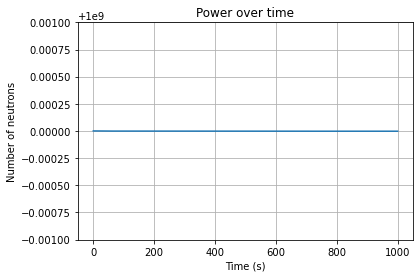

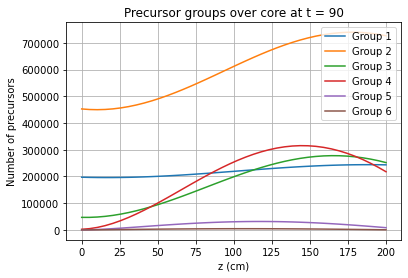

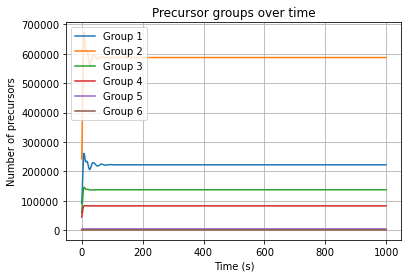

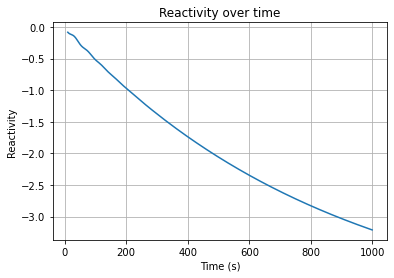

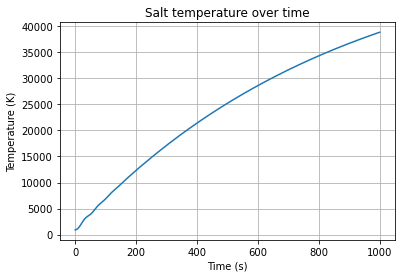

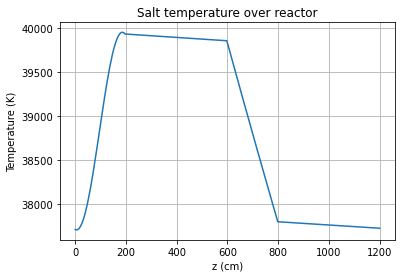

In [5]:
plt.plot(t_values, power)
plt.title('Power over time')
plt.xlabel('Time (s)')
plt.ylabel('Number of neutrons')
plt.grid()
plt.show()

z_core = np.linspace(0, dz * n_core, n_core)
z_whole = np.linspace(0, dz * n_elements, n_elements)
plt.plot(z_core, precursors[90,:n_core, 0], label = 'Group 1')
plt.plot(z_core, precursors[90,:n_core, 1], label = 'Group 2')
plt.plot(z_core, precursors[90,:n_core, 2], label = 'Group 3')
plt.plot(z_core, precursors[90,:n_core, 3], label = 'Group 4')
plt.plot(z_core, precursors[90,:n_core, 4], label = 'Group 5')
plt.plot(z_core, precursors[90,:n_core, 5], label = 'Group 6')
plt.legend()
plt.title('Precursor groups over core at t = 90')
plt.xlabel('z (cm)')
plt.ylabel('Number of precursors')
plt.grid()
plt.show()

plt.plot(t_values, np.mean(precursors[:,:,0], axis = 1), label = 'Group 1')
plt.plot(t_values, np.mean(precursors[:,:,1], axis = 1), label = 'Group 2')
plt.plot(t_values, np.mean(precursors[:,:,2], axis = 1), label = 'Group 3')
plt.plot(t_values, np.mean(precursors[:,:,3], axis = 1), label = 'Group 4')
plt.plot(t_values, np.mean(precursors[:,:,4], axis = 1), label = 'Group 5')
plt.plot(t_values, np.mean(precursors[:,:,5], axis = 1), label = 'Group 6')
plt.title('Precursor groups over time')
plt.xlabel('Time (s)')
plt.ylabel('Number of precursors')
plt.grid()
plt.legend()
plt.show()

plt.plot(t_values[10:], reactivity[10:])
plt.title('Reactivity over time')
plt.xlabel('Time (s)')
plt.ylabel('Reactivity')
plt.grid()
plt.show()

plt.plot(t_values[:], np.mean(T_salt[:,:], axis = 1))
plt.title('Salt temperature over time')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.grid()
# plt.savefig(r'Figures\Ts over time benchmark1')
plt.show()

plt.plot(z_whole, T_salt[-1,:])
plt.title('Salt temperature over reactor')
plt.xlabel('z (cm)')
plt.ylabel('Temperature (K)')
plt.grid()
# plt.savefig(r'Figures\Ts over reactor benchmark1')
plt.show()

In [6]:
print(beta_lost*1e5)

235.75464807983937


In [7]:
g_nom = 80247  # Constant salt volume flow rate in cm^3/s
g_zt_it = np.linspace(0, 3*g_nom, 5)

# Pre-compute constant arrays
surface_salt_values = surface_salt(n_elements)
heat_ex_values = heat_ex(n_elements)
circumference = O(n_elements)
T_he_values = T_he(n_elements)
rho_cp_t_values = rho_cp_t(n_elements)

# Time parameters
t_start = 0
t_end = 500  # End time of simulation in seconds
dt = 1  # Time step size in seconds
t_values = np.arange(t_start, t_end, dt)

# Creating correct size matrices
precursors = np.zeros((len(t_values), n_elements, 6))
power = np.zeros(len(t_values)) 
T_salt = np.zeros((len(t_values), n_elements))
reactivity = np.zeros(len(t_values))

# Initial conditions
power[0] = 1e9 #* p_fiss / (Lambda * nu) # Initial power
for g in range(6):
    precursors[0,:,g] = beta_eff_groups[g] / (lambda_groups[g] * Lambda) * flux_flat / (dz * surface_salt_values) * power[0]  # Initial precursor concentrations for each group
T_salt[0] = T_0_s * np.ones(n_elements)  # Initial temperature of salt in Celsius
reactivity[0] = 0

# Initialize matrices for precursor and temperatures
A = np.zeros((n_elements, n_elements)) 
C = np.zeros((n_elements, n_elements))

beta_lost_list = []

# Time loop
for g in g_zt_it:
    g_zt_values = g
    print(f'Iteration: {g/g_nom}')  # Print the current iteration number and overwrite it on the next iteration
    for t in range(len(t_values) - 1):
        print(f'Iteration: {t}', end='\r')  # Print the current iteration number and overwrite it on the next iteration

        for i in range(n_elements):
            C[i,i] = a_j_temp_s(i)
            C[i,i-1] = b_j_temp_s(i)
        D = B_j_s(t)

        T_salt[t+1,:] = np.linalg.solve(C, D)

        reactivity[t+1] = alpha * (np.sum(flux_sine * T_salt[t+1,:]) - T_0_s) 

        for g in range(6):
            for i in range(n_elements):
                A[i, i] = a_j_precursor(i, g)
                A[i, i - 1] = b_j_precursor(i)
            B = B_j_precursor(g, t)

            precursors[t+1,:,g] = np.linalg.solve(A, B)

        sums = np.zeros(6)
        for g in range(6):
            sums[g] = lambda_groups[g] * np.sum(surface_salt_values * dz * precursors[t+1,:,g] * adjoint_flux_flat) / np.sum(flux_sine * adjoint_flux_flat)
        beta_lost = total_beta_eff - Lambda / power[t] * np.sum(sums)

        first_term = (1 / dt - (beta_lost - total_beta_eff) / Lambda)**-1
        second_term = power[t] / dt + np.sum(sums)
        power[t+1] = first_term * second_term
    beta_lost_list.append(beta_lost)

Iteration: 0.0


KeyboardInterrupt: 

In [ ]:
plt.plot(g_zt_it/g_nom, np.array(beta_lost_list)*1e5)
plt.xlabel('Flowrate g (fraction of nominal flow-rate)')
plt.ylabel('Reactivity lost [pcm]')
# plt.grid()
# plt.savefig(r'Figures\reactivity vs flowrate', dpi=300)
plt.show()

plt.plot(t_values, power)
plt.title('Power over time')
plt.xlabel('Time (s)')
plt.ylabel('Power')
plt.grid()
plt.show()

In [8]:
def g_zt(t):
    if t < 0.5625:
        g_zt = g_nom * (np.exp(t * 0.5993) -1)
    elif 0.5625 < t < 10:
        g_zt = g_nom * (1 - np.exp(-(t - 0.15625) / 0.793))
    else:
        g_zt = g_nom
    return g_zt

# Pre-compute constant arrays
surface_salt_values = surface_salt(n_elements)
heat_ex_values = heat_ex(n_elements)
circumference = O(n_elements)
T_he_values = T_he(n_elements)

# Time parameters
t_start = 0
t_end = 50  # End time of simulation in seconds
dt = 0.01  # Time step size in seconds
t_values = np.arange(t_start, t_end, dt)

# Creating correct size matrices
precursors = np.zeros((len(t_values), n_elements, 6))
power = np.zeros(len(t_values)) 
T_salt = np.zeros((len(t_values), n_elements))
reactivity = np.zeros(len(t_values))
rho_rod = np.zeros((len(t_values)))
beta_lost = np.zeros((len(t_values)))

# Initial conditions
power[0] = 1e9 # Initial number of neutrons
for i in range(6):
    precursors[0,:,i] = beta_eff_groups[i] / (Lambda * lambda_groups[i]) * flux_sine * power[0] / (dz * surface_salt_values)  # Initial precursor concentrations for each group
T_salt[0] = T_0_s * np.ones(n_elements)  # Initial temperature of salt in Celsius
reactivity[0] = 0

# Initialize matrices for precursor and temperatures
A = np.zeros((n_elements, n_elements)) 
C = np.zeros((n_elements, n_elements))

# Time loop
for t in range(len(t_values) - 1):
    print(f'Iteration: {t}', end='\r')  # Print the current iteration number and overwrite it on the next iteration
    g_zt_values = g_zt(t)
    
    for j in range(n_elements):
        C[j,j] = a_j_temp_s(j)
        C[j,j-1] = b_j_temp_s(j)
    D = B_j_s(t)
                      
    T_salt[t+1,:] = np.linalg.solve(C, D)
    
    reactivity[t+1] = alpha * (np.sum(flux_sine * T_salt[t+1,:]) - T_0_s) 
        
    for i in range(6):
        for j in range(n_elements):
            A[j, j] = a_j_precursor(j, i)
            A[j, j - 1] = b_j_precursor(j)
        B = B_j_precursor(i, t)
            
        precursors[t+1,:,i] = np.linalg.solve(A, B)
        
    sums = np.zeros(6)
    for i in range(6):
        sums[i] = lambda_groups[i] * np.sum(surface_salt_values * dz * precursors[t+1,:,i] * adjoint_flux_flat) / np.sum(flux_sine * adjoint_flux_flat)
    rho_rod[t+1] = Lambda / dt - Lambda / power[0] * (power[t] / dt + np.sum(sums)) + total_beta_eff
    beta_lost[t+1] = total_beta_eff - Lambda / power[t] * np.sum(sums)
    if abs(beta_lost[t+1]-beta_lost[t]) > 29.41*1e-5*dt:
        beta_lost[t+1] = beta_lost[t] + 29.41*1e-5*dt
    
    first_term = (1 / dt - (beta_lost[t+1] - total_beta_eff) / Lambda)**-1
    second_term = power[t] / dt + np.sum(sums)
    power[t+1] = first_term * second_term

KeyboardInterrupt: 

In [ ]:
plt.plot(t_values, beta_lost * 1e5, label = 'Reactivity inserted limited')
plt.xlabel('Time [s]')
plt.ylabel('Reactivity inserted [pcm]')
plt.plot(t_values, beta_lost1 * 1e5, label = 'Reactivity inserted unlimited')
plt.legend()
plt.savefig(r'Figures\reactivity inserted vs time JEF', dpi=300)
plt.show()

plt.plot(t_values, power)
plt.title('Power over time')
plt.xlabel('Time (s)')
plt.ylabel('Power')
plt.grid()
plt.show()

In [ ]:
time = np.array([0.0, 0.45, 0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 10.5, 15.0])
g_nom = 80247  # Constant salt volume flow rate in cm^3/s
fuel_flow_rate = np.array([100, 98, 95, 80, 57, 42, 28, 18, 13, 10, 2.5, 0]) * g_nom / 100

dt = 0.01

extended_time = np.arange(0.0, 70.0 + dt, dt)

interpolated_flow_rate = np.interp(extended_time, time, fuel_flow_rate)

new_fuel_flow_rate = np.copy(interpolated_flow_rate)
new_fuel_flow_rate[extended_time > 15] = 0  # Setting values after 15 seconds to zero

# Plotting the fuel flow rate vs. time
plt.plot(extended_time, new_fuel_flow_rate)
plt.xlabel("Time [s]")
plt.ylabel("Fuel Flow Rate [% of g_nom]")
plt.title("Fuel Flow Rate vs. Time")
plt.grid(True)
plt.show()

In [233]:
# Pre-compute constant arrays
surface_salt_values = surface_salt(n_elements)
heat_ex_values = heat_ex(n_elements)
circumference = O(n_elements)
T_he_values = T_he(n_elements)
rho_cp_t_values = rho_cp_t(n_elements)

# Time parameters
t_start = 0
t_end = 70  # End time of simulation in seconds
dt = 0.01 # Time step size in seconds
t_values = np.arange(t_start, t_end, dt)

# # Creating correct size matrices
precursors = np.zeros((len(t_values), n_elements, 6))
power = np.zeros(len(t_values)) 
T_salt = np.zeros((len(t_values), n_elements))
reactivity = np.zeros(len(t_values))
beta_lost = np.zeros(len(t_values))

# Initial conditions
# power[0] = 1e9 # Initial power
# for g in range(6):
#     precursors[0,:,g] = beta_eff_groups[g] / (lambda_groups[g] * Lambda) * flux_sine / (dz * surface_salt_values) * power[0]  # Initial precursor concentrations for each group
# T_salt[0] = T_0_s * np.ones(n_elements)  # Initial temperature of salt in Celsius
# reactivity[0] = 0

power[0] = power1
precursors[0] = precursors1
beta_lost[0] = beta_lost1

# Initialize matrices for precursor and temperatures
A = np.zeros((n_elements, n_elements)) 
C = np.zeros((n_elements, n_elements))

# Time loop
for t in range(len(t_values) - 1):
    print(f'Iteration: {t}', end='\r')  # Print the current iteration number and overwrite it on the next iteration

    g_zt_values = new_fuel_flow_rate[t]

    for i in range(n_elements):
        C[i,i] = a_j_temp_s(i)
        C[i,i-1] = b_j_temp_s(i)
    D = B_j_s(t)

    T_salt[t+1,:] = np.linalg.solve(C, D)

    reactivity[t+1] = alpha * (np.sum(flux_sine * T_salt[t+1,:]) - T_0_s) 

    for g in range(6):
        for i in range(n_elements):
            A[i, i] = a_j_precursor(i, g)
            A[i, i - 1] = b_j_precursor(i)
        B = B_j_precursor(g, t)

        precursors[t+1,:,g] = np.linalg.solve(A, B)

    sums = np.zeros(6)
    for g in range(6):
        sums[g] = lambda_groups[g] * np.sum(surface_salt_values * dz * precursors[t+1,:,g] * adjoint_flux_flat) / np.sum(flux_sine * adjoint_flux_flat)
    beta_lost[t+1] = total_beta_eff - Lambda / power[t] * np.sum(sums)

    first_term = (1 / dt - (beta_lost[t+1] - total_beta_eff) / Lambda)**-1
    second_term = power[t] / dt + np.sum(sums)
    power[t+1] = first_term * second_term

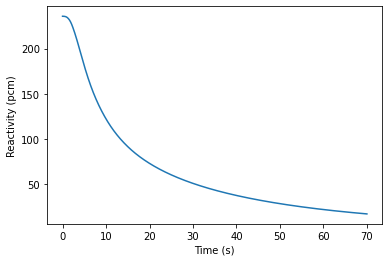

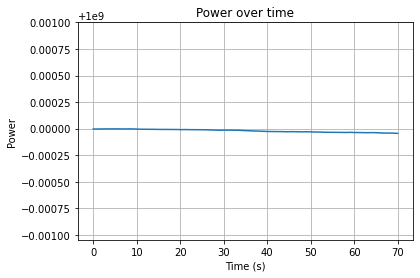

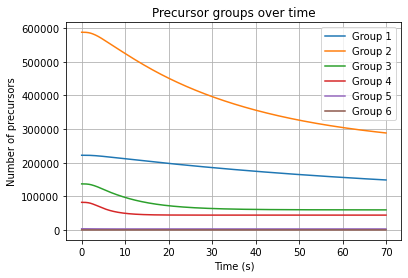

In [236]:
plt.plot(t_values[:], beta_lost[:]*1e5)
plt.xlabel('Time (s)')
plt.ylabel('Reactivity (pcm)')
# plt.grid()
plt.savefig(r'Figures\reactivity inserted vs time2 ornl')
plt.show()

plt.plot(t_values, power)
plt.title('Power over time')
plt.xlabel('Time (s)')
plt.ylabel('Power')
plt.grid()
plt.show()

plt.plot(t_values, np.mean(precursors[:,:,0], axis = 1), label = 'Group 1')
plt.plot(t_values, np.mean(precursors[:,:,1], axis = 1), label = 'Group 2')
plt.plot(t_values, np.mean(precursors[:,:,2], axis = 1), label = 'Group 3')
plt.plot(t_values, np.mean(precursors[:,:,3], axis = 1), label = 'Group 4')
plt.plot(t_values, np.mean(precursors[:,:,4], axis = 1), label = 'Group 5')
plt.plot(t_values, np.mean(precursors[:,:,5], axis = 1), label = 'Group 6')
plt.title('Precursor groups over time')
plt.xlabel('Time (s)')
plt.ylabel('Number of precursors')
plt.grid()
plt.legend()
plt.show()

# power1 = power[-1]
# precursors1 = precursors[-1]
# beta_lost1 = beta_lost

In [57]:
# g_zt_values = power/(rho_cp_t(T_salt[:,n_core] - T_salt[:,0]))
alpha = -8.46 - 4.68

# Pre-compute constant arrays
surface_salt_values = surface_salt(n_elements)
heat_ex_values = heat_ex(n_elements)
circumference = O(n_elements)
T_he_values = T_he(n_elements)

# Time parameters
t_start = 0
t_end = 5000  # End time of simulation in seconds
dt = 1  # Time step size in seconds
t_values = np.arange(t_start, t_end, dt)

# Creating correct size matrices
precursors = np.zeros((len(t_values), n_elements, 6))
power = np.zeros(len(t_values)) 
T_salt = np.zeros((len(t_values), n_elements))
reactivity = np.zeros(len(t_values))
beta_lost = np.zeros((len(t_values)))

# Initial conditions
power[0] = 4.1*1e3
for i in range(6):
    precursors[0,:,i] = beta_eff_groups[i] / (Lambda * lambda_groups[i]) * flux_sine * power[0] / (dz * surface_salt_values)  # Initial precursor concentrations for each group
reactivity[0] = 0

T_salt[0,:n_core] = np.linspace(625.22+273.15, 638.89+273.15, n_core)
T_salt[0, n_core:n_core+n_pipe1] = 638.89+273.15
T_salt[0, n_core+n_pipe1:n_core+n_pipe1+n_he] = np.linspace(625.22+273.15, 638.89+273.15, n_he)
T_salt[0,n_core+n_pipe1+n_he:] = 625.22+273.15
g_zt_values = 64

# Initialize matrices for precursor and temperatures
A = np.zeros((n_elements, n_elements)) 
C = np.zeros((n_elements, n_elements))

# Time loop
for t in range(len(t_values) - 1):
    print(f'Iteration: {t}', end='\r')  # Print the current iteration number and overwrite it on the next iteration
    
    if t > 0:
        g_zt_values = power[t]/(rho_cp_fuel*(T_salt[t,n_core] - T_salt[t,0]))
    
    for j in range(n_elements):
        C[j,j] = a_j_temp_s(j)
        C[j,j-1] = b_j_temp_s(j)
    D = B_j_s(t)
                      
    T_salt[t+1,:] = np.linalg.solve(C, D)
    
    reactivity[t+1] = alpha * (np.sum(flux_sine * T_salt[t+1,:]) - T_0_s) 
        
    for i in range(6):
        for j in range(n_elements):
            A[j, j] = a_j_precursor(j, i)
            A[j, j - 1] = b_j_precursor(j)
        B = B_j_precursor(i, t)
            
        precursors[t+1,:,i] = np.linalg.solve(A, B)
        
    sums = np.zeros(6)
    for i in range(6):
        sums[i] = lambda_groups[i] * np.sum(surface_salt_values * dz * precursors[t+1,:,i] * adjoint_flux_flat) / np.sum(flux_sine * adjoint_flux_flat)
    
    beta_lost[t+1] = total_beta_eff - Lambda / (power[t]) * np.sum(sums)
    first_term = (1 / dt - (beta_lost[t+1] - total_beta_eff) / Lambda)**-1
    second_term = power[t] / dt + np.sum(sums)
    power[t+1] = first_term * second_term

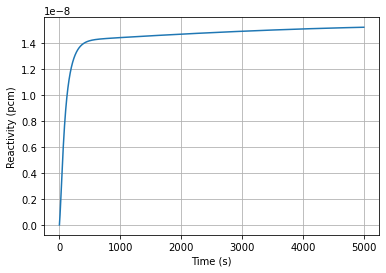

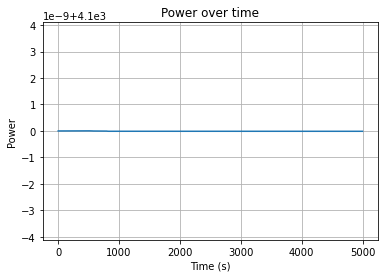

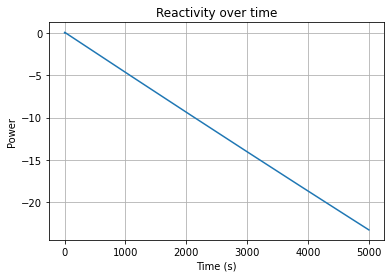

In [58]:
plt.plot(t_values, beta_lost)
plt.xlabel('Time (s)')
plt.ylabel('Reactivity (pcm)')
plt.grid()
# plt.savefig(r'Figures\reactivity inserted vs time')
plt.show()

plt.plot(t_values, power)
plt.title('Power over time')
plt.xlabel('Time (s)')
plt.ylabel('Power')
plt.grid()
plt.show()

plt.plot(t_values, reactivity)
plt.title('Reactivity over time')
plt.xlabel('Time (s)')
plt.ylabel('Power')
plt.grid()
plt.show()

In [65]:
P_0 = 64 * rho_cp_fuel * ((638.89) - (625.22))
P_0

3925.059444799988